In [1]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from global_land_mask import globe
import seaborn as sns
import sys
from math import sqrt

sys.path.append(os.path.expanduser("~/geoscience/repos/tcha"))
sys.path.append(os.path.expanduser("~/geoscience/repos/tcha/intensity"))

from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units

from intensity.era5_extract import load_otcr_df
from intensity.tc_intensity_analysis import find_dP, Hurricane

sys.path.append(os.path.expanduser("~/geoscience/repos/tcrm"))
from wind.windmodels import PowellWindProfile
from PressureInterface.pressureProfile import PrsProfile
from TrackGenerator.trackSize import rmax
from TrackGenerator.TrackGenerator import SamplePressure
from Utilities.loadData import getPoci

sns.set_theme()

DATA_DIR = os.path.expanduser("~/geoscience/data")



/Users/kieran/geoscience/repos/tcrm/wind/windmodels.py:50: UserWarning: Compiled wind models not found - defaulting to slower python wind models
  warnings.warn("Compiled wind models not found - defaulting to slower python wind models")


Done imports


In [2]:
from hurr import theory

In [3]:
DATA_DIR = os.path.expanduser("~/geoscience/data")
dataFile = os.path.join(DATA_DIR, "OTCR_alldata_final_external.csv")
df = pd.read_csv(dataFile, na_values=[' '], nrows=13743)
df['TM']= pd.to_datetime(df.TM, format="%d/%m/%Y %H:%M", errors='coerce')


mask = ~pd.isnull(df.TM)
float_cols = ['CENTRAL_PRES', 'ROCI (km)', 'POCI (hPa)', 'Vmax (kn)', 'RMW (km)']
for col in float_cols:
    df[col] = df[col].astype(float)
    mask &= ~pd.isnull(df[col])
    
df = df[mask].copy()
mask = df['CENTRAL_PRES'] < df['POCI (hPa)']
df = df[mask].copy()

/Users/kieran/miniforge3/envs/wave-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (85,86,94,95,96,99,100,104,105,107,108,115,116,117,120,121,125,126,127,128,129,130,138,139,140,143,144,148,149,150,151,152,160,161,162,165,166,170,171) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
def analysis(vm_pred, vm_actual, cecd=1):
    plt.figure(1, figsize=(5, 5))
    objects = ('TD', 'TS', 'Cat. One', 'Cat. 2', 'Cat. 3', 'Cat. 4', 'Cat 5.')
    y_pos = np.arange(len(objects))
    counts1 = np.zeros_like(y_pos)

    counts1[0] = (vm_pred <= 17).sum()
    counts1[1] = ((vm_pred > 17) & (vm_pred <= 32)).sum()
    counts1[2] = ((vm_pred > 32) & (vm_pred <= 42)).sum()
    counts1[3] = ((vm_pred > 42) & (vm_pred <= 49)).sum()
    counts1[4] = ((vm_pred > 49) & (vm_pred <= 58)).sum()
    counts1[5] = ((vm_pred > 58) & (vm_pred <= 70)).sum()
    counts1[6] = ((vm_pred > 70)).sum()

    counts2 = np.zeros_like(y_pos)

    counts2[0] = (vm_actual <= 17).sum()
    counts2[1] = ((vm_actual > 17) & (vm_actual <= 32)).sum()
    counts2[2] = ((vm_actual > 32) & (vm_actual <= 42)).sum()
    counts2[3] = ((vm_actual > 42) & (vm_actual <= 49)).sum()
    counts2[4] = ((vm_actual > 49) & (vm_actual <= 58)).sum()
    counts2[5] = ((vm_actual > 58) & (vm_actual <= 70)).sum()
    counts2[6] = ((vm_actual > 70)).sum()

    plt.bar(y_pos, counts1, align='center', alpha=0.5, label='Simulated')
    plt.bar(y_pos, counts2, align='center', alpha=0.5, label='Observed')

    plt.xticks(y_pos, objects)
    plt.ylabel('Count')
    plt.title('Landfall Intensity')
    plt.legend()
    
    indf = load_otcr_df(DATA_DIR)
    era5 = np.load(os.path.join(DATA_DIR, "tc_intensity_era5.npy"))
    bran = np.load(os.path.join(DATA_DIR, "tc_intensity_bran2020.npy"))
    rh = np.load(os.path.join(DATA_DIR, "tc_intensity_rh.npy"))

    for i, var in enumerate(["sst", "sp", "d2", "t2"]): indf[var] = era5[:, i]
    indf["hm"] = bran[:, 0]
    indf['rh'] = rh[:, 21]

    indf = indf[["DISTURBANCE_ID", "TM", "sst", "sp", "t2", "d2"]]
    indf.columns = ["DISTURBANCE_ID", "time", "sst", "sp", "t2", "d2"]
    mpidf = df.merge(indf, on=["DISTURBANCE_ID", "time"])

    mpi = np.zeros(len(mpidf), dtype=np.float32)
    for i in range(len(mpidf)):

        sst = mpidf.sst.iloc[i] 
        sp = mpidf.sp.iloc[i]
        t2 = mpidf.t2.iloc[i]
        d2 = mpidf.d2.iloc[i]

        t2 = units.Quantity(t2, "K")
        d2 = units.Quantity(d2, "K")
        h_a = relative_humidity_from_dewpoint(t2, d2)
        sst = sst - 273.15  # convert K -> C
        sp = sp / 100  # convert Pa -> hPa

        theory(cecd, h_a, sst, -75, sp, mpi[i:i+1])
    

    mpidf['mpi'] = mpi
    # mpidf['rel'] = mpidf.vmax / mpidf.mpi
    sim_lmi = mpidf.groupby('DISTURBANCE_ID').vmax.max() / mpidf.groupby('DISTURBANCE_ID').mpi.max()
    real_lmi = mpidf.groupby('DISTURBANCE_ID').vmax_obs.max() / mpidf.groupby('DISTURBANCE_ID').mpi.max()
    
    plt.figure(2, figsize=(5, 5))
    h = plt.hist(sim_lmi, alpha=0.5, label="Simulated")
    plt.hist(real_lmi, alpha=0.5, label="Observed", bins=h[1])
    plt.ylabel("Count")
    plt.xlabel("Maximum intensity normalised by maximum MPI")
    
    plt.legend()
    plt.show()
    
    
def analyze_delta(vm_pred, vm_pred_control):
    objects = ('TD', 'TS', 'Cat. One', 'Cat. 2', 'Cat. 3', 'Cat. 4', 'Cat 5.')
    y_pos = np.arange(len(objects))
    counts1 = np.zeros_like(y_pos)

    counts1[0] = (vm_pred <= 17).sum()
    counts1[1] = ((vm_pred > 17) & (vm_pred <= 32)).sum()
    counts1[2] = ((vm_pred > 32) & (vm_pred <= 42)).sum()
    counts1[3] = ((vm_pred > 42) & (vm_pred <= 49)).sum()
    counts1[4] = ((vm_pred > 49) & (vm_pred <= 58)).sum()
    counts1[5] = ((vm_pred > 58) & (vm_pred <= 70)).sum()
    counts1[6] = ((vm_pred > 70)).sum()

    counts2 = np.zeros_like(y_pos)

    counts2[0] = (vm_pred_control <= 17).sum()
    counts2[1] = ((vm_pred_control > 17) & (vm_pred_control <= 32)).sum()
    counts2[2] = ((vm_pred_control > 32) & (vm_pred_control <= 42)).sum()
    counts2[3] = ((vm_pred_control > 42) & (vm_pred_control <= 49)).sum()
    counts2[4] = ((vm_pred_control > 49) & (vm_pred_control <= 58)).sum()
    counts2[5] = ((vm_pred_control > 58) & (vm_pred_control <= 70)).sum()
    counts2[6] = ((vm_pred_control > 70)).sum()
    
    plt.figure(1, figsize=(10, 10))
    
    plt.xticks(y_pos, objects)
    plt.bar(y_pos, (counts1  - counts2) / counts2, align='center', alpha=0.5, label='Simulated')
    plt.ylabel('Difference')
    plt.title('Landfall Intensity')
    plt.legend()
    
    

    
    
    
def get_landfall(df):
    ids = []
    vm_pred = []
    pc_pred = []
    vm_actual = []
    pc_actual = []
    for name, g in df.groupby('DISTURBANCE_ID'):
        for j, i in enumerate(g.index[:-1]):
            row = g.loc[i]
            lat_next, lon_next = g.loc[g.index[j + 1]].lat, g.loc[g.index[j + 1]].lon
            if globe.is_land(lat_next, lon_next):
                vm_pred.append(row.vmax)
                vm_actual.append(row.vmax_obs)
                pc_pred.append(row.pmin)
                pc_actual.append(row.pmin_obs)
                ids.append(row.DISTURBANCE_ID)
                break

    ids = np.array(ids)
    vm_pred = np.array(vm_pred)
    vm_actual = np.array(vm_actual)
    pc_pred = np.array(pc_pred)
    pc_actual = np.array(pc_actual)
    
    return ids, vm_pred, vm_actual, pc_pred, pc_actual

## No ocean mixing

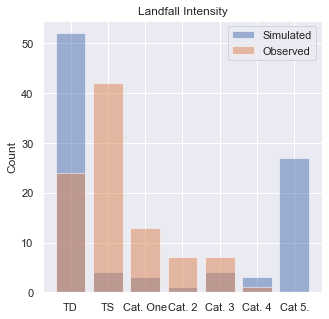

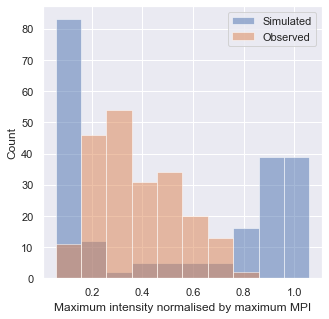

In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity.csv"))
df.time = pd.to_datetime(df.time)
ids, vm_pred_control, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred_control, vm_actual)


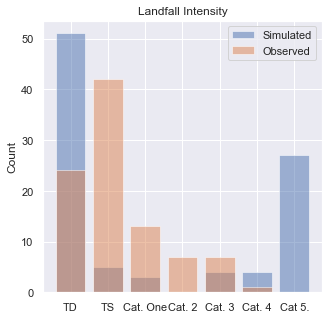

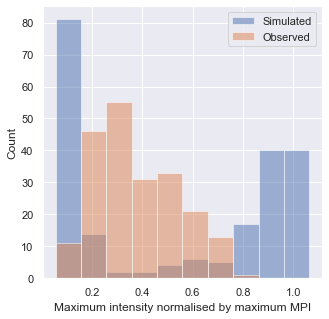

In [7]:
df = pd.read_csv(os.path.join(DATA_DIR, "smooth_predicted_intensity.csv"))
df.time = pd.to_datetime(df.time)
ids, vm_pred_control, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred_control, vm_actual)

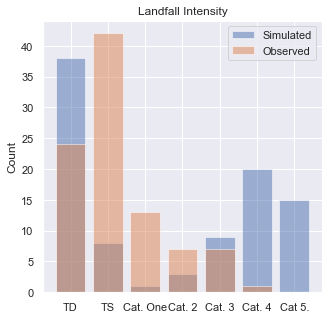

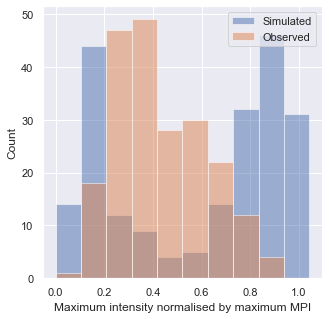

In [8]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_cecd_0.8.csv"))
df.time = pd.to_datetime(df.time)
ids, vm_pred, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred, vm_actual, cecd=0.8)

In [9]:
vm_actual

array([41.15552, 15.43332, 23.14998, 15.43332, 51.4444 , 48.87218,
       41.15552, 41.15552, 15.43332, 38.5833 , 20.57776, 15.43332,
       25.7222 , 54.01662, 18.00554, 18.00554, 20.57776, 28.29442,
       12.8611 , 20.57776, 33.43886, 12.8611 , 38.5833 , 15.43332,
       25.7222 , 18.00554, 51.4444 , 30.86664, 25.7222 , 59.16106,
       15.43332, 30.86664, 20.57776, 20.57776, 20.57776, 18.00554,
       15.43332, 56.58884, 18.00554, 23.14998, 20.57776, 23.14998,
       30.86664, 18.00554, 18.00554, 46.29996, 23.14998, 48.87218,
       36.01108, 20.57776, 12.8611 , 51.4444 , 20.57776, 38.5833 ,
       12.8611 , 18.00554, 25.7222 , 23.14998, 25.7222 , 25.7222 ,
       23.14998, 18.00554, 10.28888, 12.8611 , 33.43886, 15.43332,
       41.15552, 15.43332, 20.57776, 25.7222 , 56.58884, 12.8611 ,
       28.29442, 41.15552, 12.8611 , 12.8611 , 43.72774,  7.71666,
       38.5833 , 15.43332, 18.00554, 46.29996, 28.29442,  0.     ,
       18.00554, 15.43332, 46.29996,  7.71666, 56.58884, 36.01

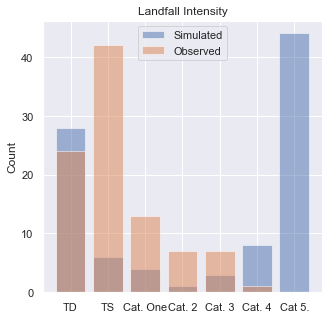

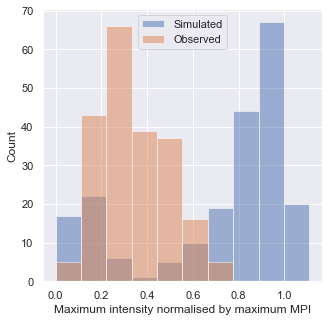

In [7]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_cecd_1.2.csv"))
df.time = pd.to_datetime(df.time)
ids, vm_pred, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred, vm_actual, cecd=1.2)

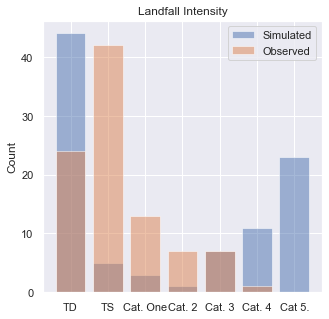

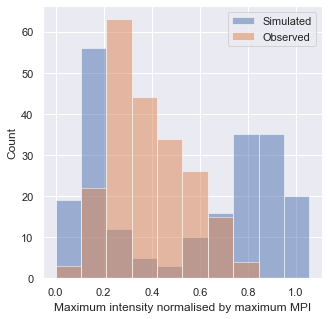

In [8]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_efrac_0.5.csv"))
df.time = pd.to_datetime(df.time)
ids, vm_pred, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred, vm_actual)

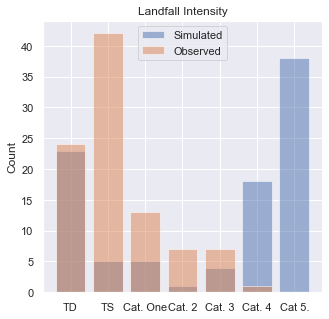

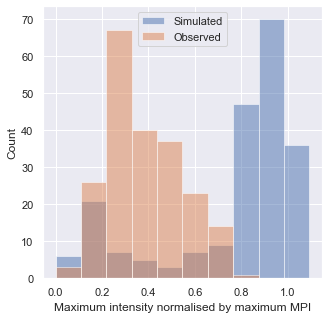

In [9]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_efrac_0.9.csv"))
df.time = pd.to_datetime(df.time)
ids, vm_pred, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred, vm_actual)

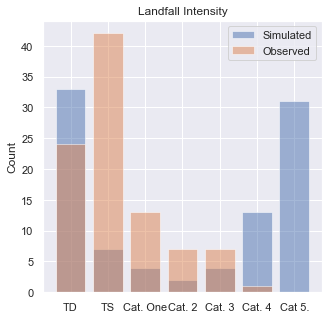

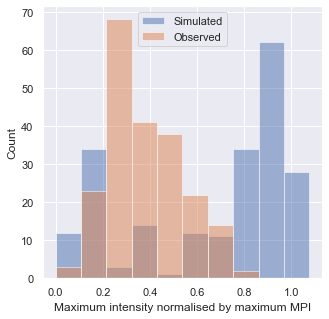

In [10]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_tinit_1.0.csv"))
df.time = pd.to_datetime(df.time)
ids, vm_pred, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred, vm_actual)


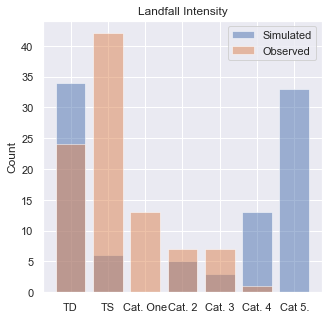

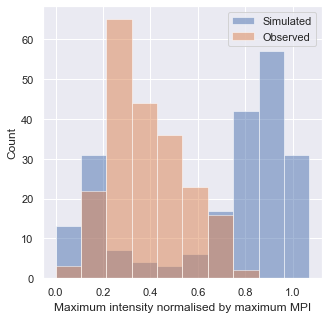

In [11]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_tinit_4.0.csv"))
df.time = pd.to_datetime(df.time)

ids, vm_pred, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred, vm_actual)

## Ocean mixing

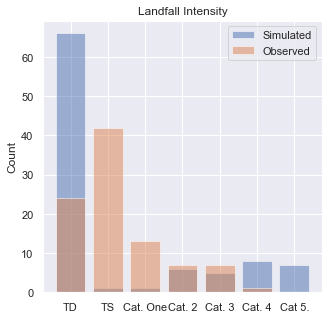

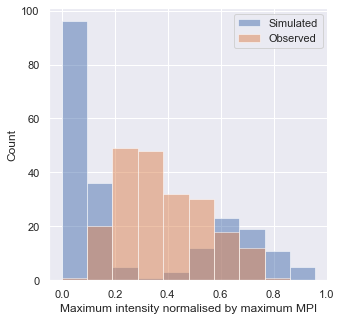

In [12]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_ocean_mixing.csv"))
df.time = pd.to_datetime(df.time)

ids_mix, vm_pred_mix, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred_mix, vm_actual)

mix_dict = {id_: vm for id_, vm in zip(ids_mix, vm_pred_mix)}

df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_new.csv"))
df.time = pd.to_datetime(df.time)
control_ids, vm_pred_control, vm_actual, pc_pred, pc_actual = get_landfall(df)
control_dict = {id_: vm for id_, vm in zip(control_ids, vm_pred_control)}


bad_ids = ids[vm_pred_control < vm_pred]

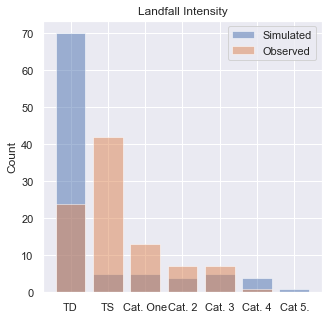

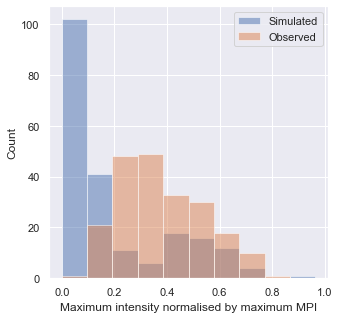

In [14]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_shear_ocean_mixing.csv"))
df.time = pd.to_datetime(df.time)
ids_mix, vm_pred_mix, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred_mix, vm_actual)


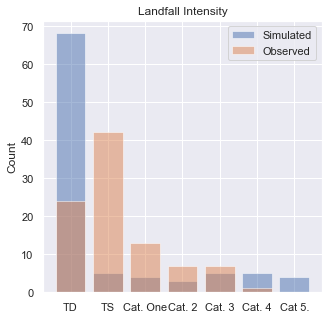

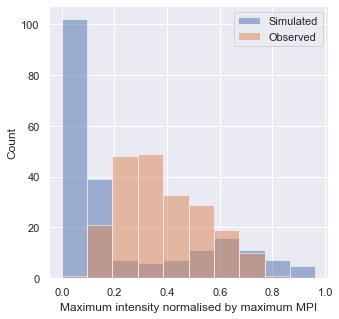

In [15]:
df = pd.read_csv(os.path.join(DATA_DIR, "predicted_intensity_shear.csv"))
df.time = pd.to_datetime(df.time)
ids_mix, vm_pred_mix, vm_actual, pc_pred, pc_actual = get_landfall(df)
analysis(vm_pred_mix, vm_actual)